In [7]:
import tensorflow as tf
import pandas as pd
import numpy as np

from utils.df_loader import (
    load_adult_df,
    load_compas_df,
    load_german_df,
    load_diabetes_df,
    load_breast_cancer_df,
)
from sklearn.model_selection import train_test_split
from utils.preprocessing import preprocess_df
from utils.models import (
    train_models,
    evaluation_test,
    save_models,
    load_models,
)

import utils.deepfool as util_deepfool
import utils.carlini as util_carlini
import utils.lowprofool as util_lowprofool


from utils.save import save_result_as_csv, save_datapoints_as_npy, process_result, process_datapoints

seed = 123
# tf.random.set_seed(seed)
# np.random.seed(seed)

In [8]:
import warnings
# warnings.filterwarnings("ignore", message="divide by zero encountered in divide")
pd.options.mode.chained_assignment = None # suppress "SettingWithCopyWarning" warning

In [9]:
num_instances = 128 # (1)&(2) 20

TRAIN_MODEL = False # (1)True(2)False
RUN_ART = True
NUM_ONLY = True

# attack

RUN_DEEPFOOL = False
RUN_CARLINI = False
RUN_LOWPROFOOL = True

In [10]:
if RUN_ART:
    tf.compat.v1.disable_eager_execution()

print("TF version: ", tf.__version__)
print("Eager execution enabled: ", tf.executing_eagerly())  # False    

TF version:  2.10.0
Eager execution enabled:  False


In [11]:
if NUM_ONLY:
    dataset = [
    # "diabetes",
    "breast_cancer",
    ]
else:
    dataset = [
    "adult",
    "german",
    "compas",
    # "diabetes",
    # "breast_cancer",
    ]

Dataset Name: [breast_cancer]


c:\Users\n10599070\Miniconda3\envs\xai\lib\site-packages\keras\engine\training_v1.py:2356: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


Model: [Decision Tree] | Accuracy: [0.9649] | Precision: [0.9744 | Recall: [0.9268] | F1: [0.9500]


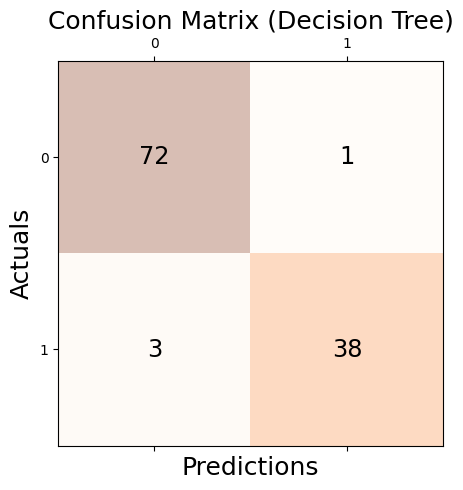

Model: [Random Forest] | Accuracy: [0.9825] | Precision: [1.0000 | Recall: [0.9512] | F1: [0.9750]


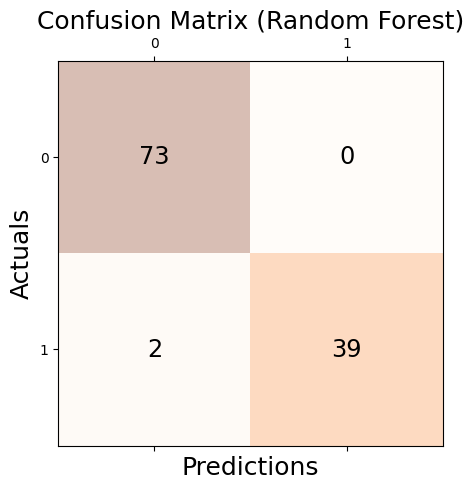

Model: [Linear Support Vector Classification] | Accuracy: [0.9912] | Precision: [1.0000 | Recall: [0.9756] | F1: [0.9877]


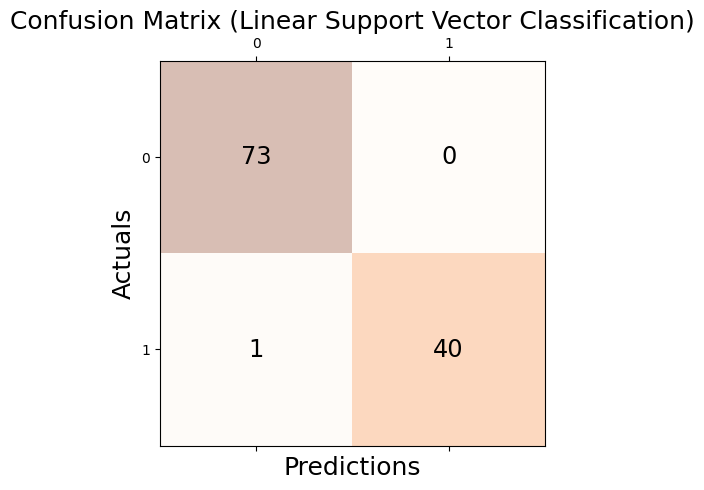

Model: [Logistic Regression] | Accuracy: [0.9649] | Precision: [1.0000 | Recall: [0.9024] | F1: [0.9487]


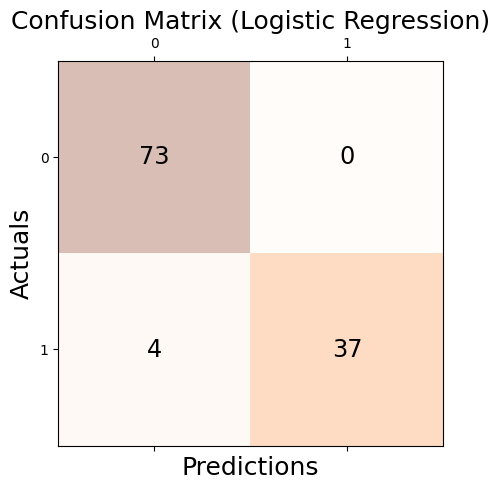

Model: [Neural Network (single output unit)] | Accuracy: [0.9825] | Precision: [0.9756 | Recall: [0.9756] | F1: [0.9756]


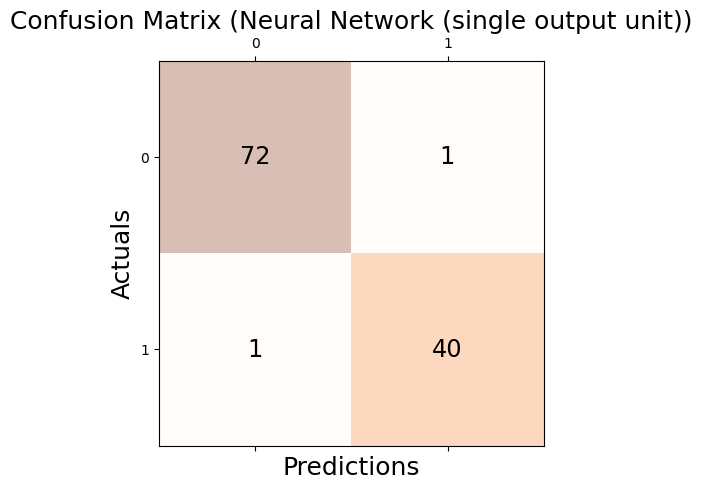

Model: [Neural Network (two output units)] | Accuracy: [0.9737] | Precision: [0.9750 | Recall: [0.9512] | F1: [0.9630]


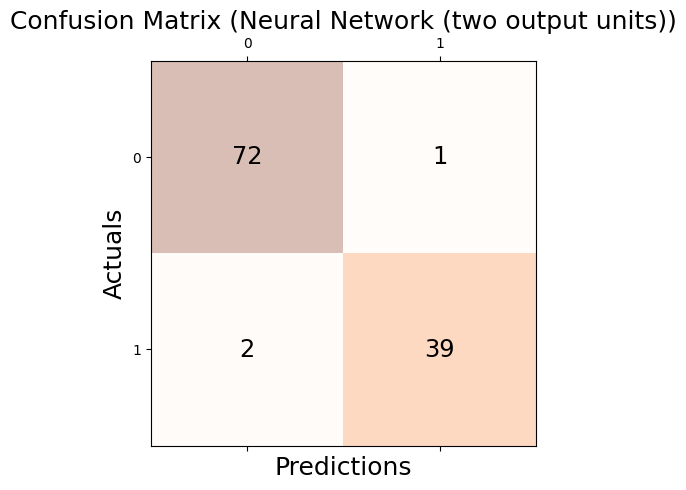

Feature range:
(0, 1)
Finding adversarial examples for lr


LowProFool: 100%|██████████| 100/100 [00:00<00:00, 877.12it/s]


Finding adversarial examples for svc


LowProFool: 100%|██████████| 100/100 [00:00<00:00, 840.14it/s]


Finding adversarial examples for nn_2


LowProFool: 100%|██████████| 100/100 [00:00<00:00, 300.89it/s]


Original data points and adversarial examples have been saved to ./datapoints/lowprofool_l_1_breast_cancer
Result has been saved to ./results/lowprofool_l_1_breast_cancer


In [14]:
#### Select dataset ####
for dataset_name in dataset: 
    print(f"Dataset Name: [{dataset_name}]")
    if dataset_name == "adult":
        dataset_loading_fn = load_adult_df
    elif dataset_name == "german":
        dataset_loading_fn = load_german_df
    elif dataset_name == "compas":
        dataset_loading_fn = load_compas_df
    elif dataset_name == "diabetes":
        dataset_loading_fn = load_diabetes_df
    elif dataset_name == "breast_cancer":
        dataset_loading_fn = load_breast_cancer_df
    else:
        raise Exception("Unsupported dataset")

    df_info = preprocess_df(dataset_loading_fn)

    train_df, test_df = train_test_split(
        df_info.dummy_df, train_size=0.8, random_state=seed, shuffle=True
    )
    X_train = np.array(train_df[df_info.ohe_feature_names])
    y_train = np.array(train_df[df_info.target_name])
    X_test = np.array(test_df[df_info.ohe_feature_names])
    y_test = np.array(test_df[df_info.target_name])

    if TRAIN_MODEL:
        ## Train models.
        models = train_models(X_train, y_train)
        ## Save models.
        save_models(models, dataset_name)

    ### Load models
    models = load_models(X_train.shape[-1], dataset_name)

    ### Print out accuracy on testset.
    evaluation_test(models, X_test, y_test)

    if RUN_ART:
        # DeepFool attack
        if RUN_DEEPFOOL:
            deepfool_results = util_deepfool.generate_deepfool_result(
                    df_info,
                    models,
                    num_instances,
                    X_test,
                    y_test,
                    models_to_run=["lr","svc","nn_2"],
                )
            deepfool_datapoints = process_datapoints(deepfool_results)
            save_datapoints_as_npy("deepfool", dataset_name, deepfool_datapoints)
            deepfool_result_dfs = process_result(deepfool_results, df_info)
            save_result_as_csv("deepfool", dataset_name, deepfool_result_dfs)

        if RUN_CARLINI:

            carlini_l_2_results = util_carlini.generate_carlini_result(
                    df_info,
                    models,
                    num_instances,
                    X_test,
                    y_test,
                    norm="l_2", #["l_2", "l_inf"]
                    models_to_run=["lr","svc","nn_2"],
                )
            carlini_l_2_datapoints = process_datapoints(carlini_l_2_results)
            save_datapoints_as_npy("carlini_l_2", dataset_name, carlini_l_2_datapoints)
            carlini_l_2_result_dfs = process_result(carlini_l_2_results, df_info)
            save_result_as_csv("carlini_l_2", dataset_name, carlini_l_2_result_dfs)

            carlini_l_inf_results = util_carlini.generate_carlini_result(
                    df_info,
                    models,
                    num_instances,
                    X_test,
                    y_test,
                    norm="l_inf", #["l_2", "l_inf"]
                    models_to_run=["lr","svc","nn_2"],
                )
            carlini_l_inf_datapoints = process_datapoints(carlini_l_inf_results)
            save_datapoints_as_npy("carlini_l_inf", dataset_name, carlini_l_inf_datapoints)
            carlini_l_inf_result_dfs = process_result(carlini_l_inf_results, df_info)
            save_result_as_csv("carlini_l_inf", dataset_name, carlini_l_inf_result_dfs)

        if NUM_ONLY and RUN_LOWPROFOOL:

            lowprofool_l_2_results = util_lowprofool.generate_lowprofool_result(
                    df_info,
                    models,
                    num_instances,
                    X_train,
                    y_train,
                    X_test,
                    y_test,
                    norm=2, #[int, float, 'inf']
                    models_to_run=["lr","svc","nn_2"],
                )
            lowprofool_l_2_datapoints = process_datapoints(lowprofool_l_2_results)
            save_datapoints_as_npy("lowprofool_l_2", dataset_name, lowprofool_l_2_datapoints)
            lowprofool_l_2_result_dfs = process_result(lowprofool_l_2_results, df_info)
            save_result_as_csv("lowprofool_2_1", dataset_name, lowprofool_l_2_result_dfs)

            lowprofool_l_inf_results = util_lowprofool.generate_lowprofool_result(
                    df_info,
                    models,
                    num_instances,
                    X_train,
                    y_train,
                    X_test,
                    y_test,
                    norm='inf', #[int, float, 'inf']
                    models_to_run=["lr","svc","nn_2"],
                )
            lowprofool_l_inf_datapoints = process_datapoints(lowprofool_l_inf_results)
            save_datapoints_as_npy("lowprofool_l_2", dataset_name, lowprofool_l_inf_datapoints)
            lowprofool_l_inf_result_dfs = process_result(lowprofool_l_inf_results, df_info)
            save_result_as_csv("lowprofool_2_1", dataset_name, lowprofool_l_inf_result_dfs)